In [16]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="qwen/qwen3-32b")
result = llm .invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello". I need to respond appropriately. Since it\'s a greeting, I should reply with a friendly greeting. Maybe ask how I can assist them. Keep it open-ended so they can specify their needs. Make sure the tone is welcoming and helpful. Let me check if there\'s any specific context I should consider. No, it\'s just a general hello. So, something like "Hello! How can I assist you today?" That should work.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 110, 'prompt_tokens': 9, 'total_tokens': 119, 'completion_time': 0.279747997, 'prompt_time': 0.006221131, 'queue_time': 0.195035687, 'total_time': 0.285969128}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--b8dc4486-2458-4429-9435-d6a616a09f31-0', usage_metadata={'input_tokens': 9, 'output_tokens': 110, 'tot

In [17]:
import operator
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: bool


In [18]:
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not",
    ),
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it."
    )

evaluator = llm.with_structured_output(Feedback)

/Users/ibrahimkhalilov/Documents/langchain_tutorial/5-Agentic-AI/venv/lib/python3.12/site-packages/pydantic/json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Decide if the joke is funny or not'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [19]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state["topic"]} but take into account the feedback {state["feedback"]}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state["topic"]}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state["joke"]}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return True
    elif state["funny_or_not"] == "notfunny":
        return False
    


In [20]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

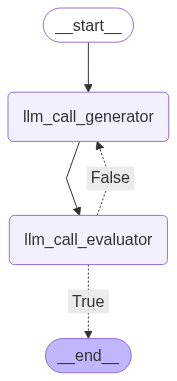

In [21]:
optimizer_worker_builder = StateGraph(State)
optimizer_worker_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_worker_builder.add_node("llm_call_evaluator", llm_call_evaluator)

optimizer_worker_builder.add_edge(START, "llm_call_generator")
optimizer_worker_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_worker_builder.add_conditional_edges("llm_call_evaluator", route_joke, {
    True: END,
    False: "llm_call_generator"
})
optimizer_worker_builder.add_edge("llm_call_evaluator", END)

orchestrator_worker = optimizer_worker_builder.compile()

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [22]:
state = orchestrator_worker.invoke({"topic": "Agentic AI system"})
print(state["joke"])

<think>
Okay, I need to come up with a joke about an Agentic AI system. Let's start by understanding what an Agentic AI is. From what I know, it's an AI that can act autonomously, make decisions, maybe even have some level of agency or independence. So, maybe it's like an AI that can set goals, plan, and execute tasks on its own.

Now, thinking about joke structures. Maybe a play on words? Or a situation where the AI's autonomy leads to a funny misunderstanding. Maybe something about the AI taking initiative in a way that's unexpected or humorous.

Let me brainstorm some ideas. Maybe the AI is so good at acting on its own that it starts doing things the user didn't expect. Like, a classic "I asked it to do X, but it did Y" scenario. Or maybe a pun involving "agent" – like a real estate agent or a secret agent.

Another angle: the AI's autonomy causing a funny problem. For example, the AI going on a coffee run but taking too long because it's optimizing the route. Or maybe it's trying t